## scRNAseq CD8 Tm in pancreatic cancer preprocessing and analysis

Author: Maha Alissa Alkhalaf

Figures: Figure 6 (G), Extended Data 21

In [27]:
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import celltypist
import scrublet as scr
import anndata as ad
from scipy.io import mmread
import os

## Data Collection

In [2]:
adata = sc.read_h5ad('../data/pancreas/pk_all.h5ad')

In [3]:
adata

AnnData object with n_obs × n_vars = 136163 × 34746
    obs: 'CELL', 'Patient', 'Type', 'Cell_type', 'celltype0', 'celltype1', 'celltype2', 'celltype3', 'Patient2', 'nCount_RNA', 'nFeature_RNA', 'Project', 'orig.ident', 'Stage', 'Grade', 'Gender', 'Age', 'Percent_mito', 'Percent_ribo', 'Percent_hemo', 'percent.mt', 'predicted.id', 'prediction.score.Fibroblast.cell', 'prediction.score.Stellate.cell', 'prediction.score.Macrophage.cell', 'prediction.score.Endothelial.cell', 'prediction.score.T.cell', 'prediction.score.B.cell', 'prediction.score.Ductal.cell.type.2', 'prediction.score.Endocrine.cell', 'prediction.score.Ductal.cell.type.1', 'prediction.score.Acinar.cell', 'prediction.score.max', 'classical_score1', 'basal_score1', 'classical_score21', 'basal_score21', 'endocrine_score_1', 'immune_score_1', 'exocrine_score_1', 'activated_stroma_score_1', 'histone_score_1', 'normal_stroma_score_1', 'olfactory_score_1', 'na_score_1'
    var: 'name'
    obsm: 'X_pca', 'X_umap'

In [4]:
adata = adata[adata.obs['Type'] == 'Tumor']

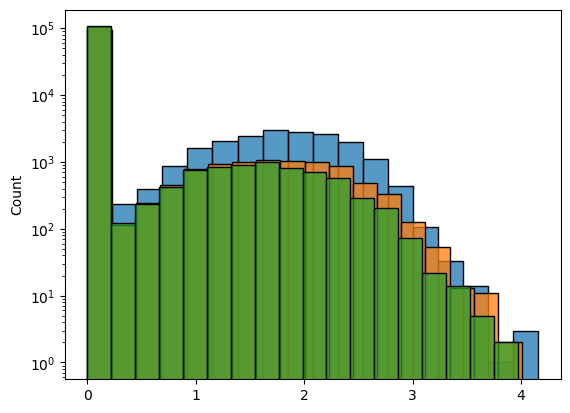

In [8]:
sns.histplot(adata.X[:, adata.var_names == 'CD3E'].toarray().flatten())
sns.histplot(adata.X[:, adata.var_names == 'CD8A'].toarray().flatten())
sns.histplot(adata.X[:, adata.var_names == 'CD8B'].toarray().flatten())

plt.yscale('log')

In [9]:
adata.obs['cell_type'] = 'unknown'

mask_cd3e = (adata.X[:, adata.var_names == 'CD3E'] > 0).toarray().flatten()
mask_cd8a = (adata.X[:, adata.var_names == 'CD8A'] > 0).toarray().flatten()
mask_cd8b = (adata.X[:, adata.var_names == 'CD8B'] > 0).toarray().flatten()
combined_mask = mask_cd3e & mask_cd8a & mask_cd8b

# Update the 'cell_type' column based on the combined mask
adata.obs.loc[combined_mask, 'cell_type'] = 'CD8 T cells'

In [10]:
adata_cd8 = adata[combined_mask, :]
adata_cd8

View of AnnData object with n_obs × n_vars = 3467 × 34746
    obs: 'CELL', 'Patient', 'Type', 'Cell_type', 'celltype0', 'celltype1', 'celltype2', 'celltype3', 'Patient2', 'nCount_RNA', 'nFeature_RNA', 'Project', 'orig.ident', 'Stage', 'Grade', 'Gender', 'Age', 'Percent_mito', 'Percent_ribo', 'Percent_hemo', 'percent.mt', 'predicted.id', 'prediction.score.Fibroblast.cell', 'prediction.score.Stellate.cell', 'prediction.score.Macrophage.cell', 'prediction.score.Endothelial.cell', 'prediction.score.T.cell', 'prediction.score.B.cell', 'prediction.score.Ductal.cell.type.2', 'prediction.score.Endocrine.cell', 'prediction.score.Ductal.cell.type.1', 'prediction.score.Acinar.cell', 'prediction.score.max', 'classical_score1', 'basal_score1', 'classical_score21', 'basal_score21', 'endocrine_score_1', 'immune_score_1', 'exocrine_score_1', 'activated_stroma_score_1', 'histone_score_1', 'normal_stroma_score_1', 'olfactory_score_1', 'na_score_1', 'cell_type'
    var: 'name'
    obsm: 'X_pca', 'X_umap'

In [13]:
len(set(adata_cd8.obs['Patient2']))

52

In [23]:
adata_cd8.obs['cell_type'] = 'cd8_t_cells'

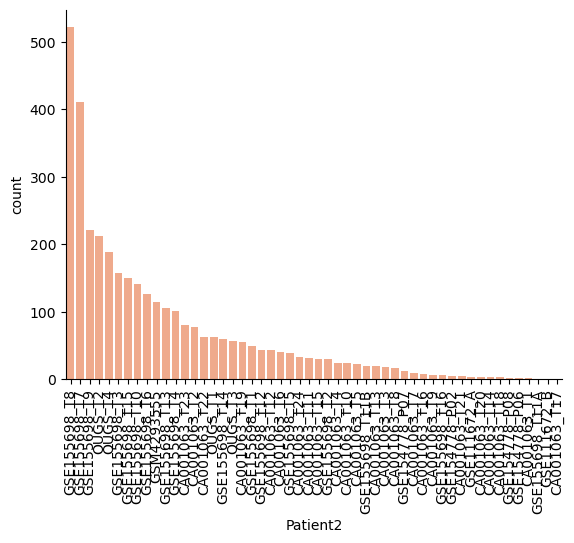

In [14]:
data = adata_cd8.obs['Patient2']

order = data.value_counts().index
sns.countplot(x=data, order=order, color='#ffa37b')

plt.xticks(rotation=90)
sns.despine()

... storing 'cell_type' as categorical


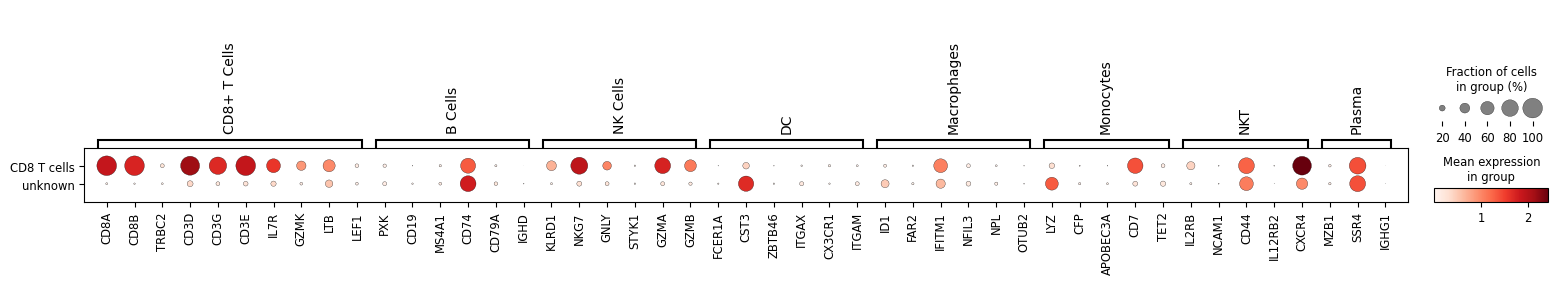

In [15]:
markers = {'CD8+ T Cells' : ['CD8A', 'CD8B', 'TRBC2', 'CD3D', 'CD3G', 'CD3E', 'IL7R', 'GZMK', 'LTB', 'LEF1'], 'B Cells' : ['PXK', 'CD19', 'MS4A1', 'CD74', 'CD79A', 'IGHD'], 'NK Cells' : ['KLRD1', 'NKG7', 'GNLY', 'STYK1', 'GZMA', 'GZMB'], 'DC' : ['FCER1A', 'CST3', 'ZBTB46', 'ITGAX', 'CX3CR1', 'ITGAM'], 'Macrophages' : ['ID1', 'FAR2', 'IFITM1', 'NFIL3', 'NPL', 'OTUB2'], 'Monocytes' : ['LYZ', 'CFP', 'APOBEC3A', 'CD7', 'TET2'], 'NKT' : ['IL2RB', 'NCAM1', 'CD44', 'IL12RB2', 'CXCR4'], 'Plasma' : ['MZB1', 'SSR4', 'IGHG1']}
sc.pl.dotplot(adata, markers, groupby = 'cell_type', dendrogram = True, show = False)

plt.savefig('../figures/panc_before_filtering_marker_genes_CD8+_T_cells.pdf', dpi = 300, bbox_inches = 'tight')

... storing 'cell_type' as categorical


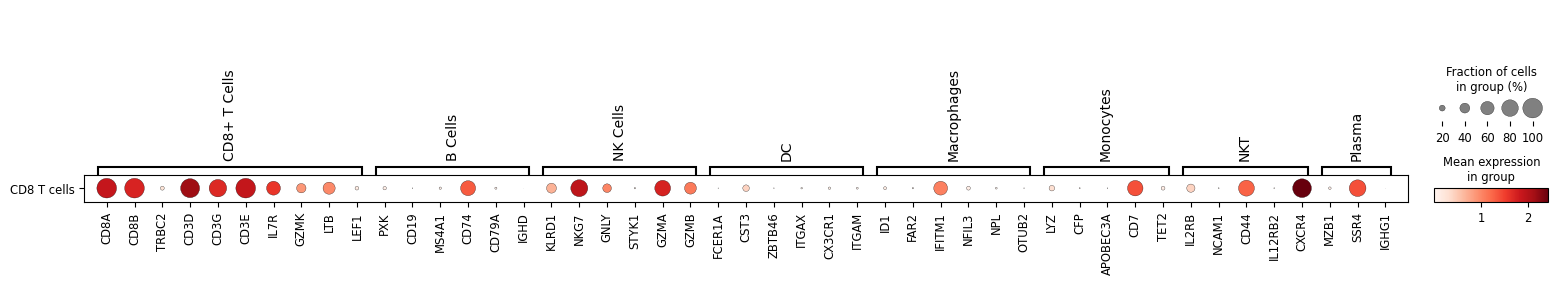

In [16]:
markers = {'CD8+ T Cells' : ['CD8A', 'CD8B', 'TRBC2', 'CD3D', 'CD3G', 'CD3E', 'IL7R', 'GZMK', 'LTB', 'LEF1'], 'B Cells' : ['PXK', 'CD19', 'MS4A1', 'CD74', 'CD79A', 'IGHD'], 'NK Cells' : ['KLRD1', 'NKG7', 'GNLY', 'STYK1', 'GZMA', 'GZMB'], 'DC' : ['FCER1A', 'CST3', 'ZBTB46', 'ITGAX', 'CX3CR1', 'ITGAM'], 'Macrophages' : ['ID1', 'FAR2', 'IFITM1', 'NFIL3', 'NPL', 'OTUB2'], 'Monocytes' : ['LYZ', 'CFP', 'APOBEC3A', 'CD7', 'TET2'], 'NKT' : ['IL2RB', 'NCAM1', 'CD44', 'IL12RB2', 'CXCR4'], 'Plasma' : ['MZB1', 'SSR4', 'IGHG1']}
sc.pl.dotplot(adata_cd8, markers, groupby = 'cell_type', dendrogram = True, show = False)

plt.savefig('../figures/panc_after_filtering_marker_genes_CD8+_T_cells.pdf', dpi = 300, bbox_inches = 'tight')

## Module score

In [17]:
single_cell = pd.read_csv('../data/gene_sets/sc_CD8_salt', sep = '\t')
single_cell.sort_values('avg_log2FC', inplace = True, ascending = False) 
single_cell.head()

,Unnamed: 0,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
7,MT1G,0.000000e+00,2.041876,0.612,0.274,0.000000e+00
8,CCDC200,0.000000e+00,1.591479,0.684,0.299,0.000000e+00
13,MT1X,3.287614e-291,1.511235,0.798,0.681,1.203300e-286
6,MT1E,0.000000e+00,1.489193,0.840,0.680,0.000000e+00
0,ATF3,0.000000e+00,1.320619,0.888,0.651,0.000000e+00


In [18]:
single_cell_upregulated_sig = list(single_cell.query('(avg_log2FC > 0) and (p_val_adj < 0.001)')['Unnamed: 0'])
single_cell_downregulated_sig = list(single_cell.query('(avg_log2FC < 0) and (p_val_adj < 0.001)')['Unnamed: 0'])


gene_set_significant = {
                       'single_cell_upregulated'   : single_cell_upregulated_sig,
                       'single_cell_downregulated' : single_cell_downregulated_sig
                       }

sc_salt_group
cd8+_high_salt    2668
cd8+_low_salt      799
Name: count, dtype: int64


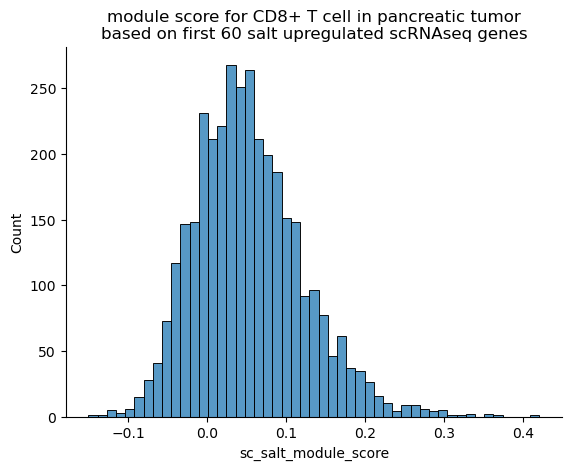

In [19]:
cutof = 60
sc.tl.score_genes(adata_cd8, gene_list=gene_set_significant['single_cell_upregulated'][:cutof], score_name='sc_salt_module_score')

threshold = 0.0000001

# Create a new column indicating high or low salt based on the threshold
adata_cd8.obs['sc_salt_group'] = pd.cut(adata_cd8.obs['sc_salt_module_score'], bins=[-float('inf'), threshold, float('inf')],
                                 labels=['cd8+_low_salt', 'cd8+_high_salt'], include_lowest=True)

print(adata_cd8.obs['sc_salt_group'].value_counts())
sns.histplot(adata_cd8.obs['sc_salt_module_score'])
plt.title(f'module score for CD8+ T cell in pancreatic tumor\nbased on first {cutof} salt upregulated scRNAseq genes')
sns.despine()

plt.savefig(f'../figures/panc_module score for CD8+ T cell in tumor\nbased on first {cutof} salt upregulated scRNAseq genes.pdf', dpi = 300, bbox_inches = 'tight')

In [24]:
def print_boxplot_stats(data, label):
    minimum = np.min(data)
    maximum = np.max(data)
    q1 = np.percentile(data, 25)
    median = np.median(data)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lower_whisker = np.max([minimum, q1 - 1.5 * iqr])
    upper_whisker = np.min([maximum, q3 + 1.5 * iqr])

    return {'min': minimum, 
           'max': maximum, 
           'q1': q1,
           'median': median,
           'q3': q3,
           'lower_whisker': lower_whisker,
           'upper_whisker': upper_whisker}
def gene_expression(adata, gene, conditions, condition):
    plt.figure(figsize = (2, 2.5), dpi = 300)

    gene_index = np.where(adata.var.index == gene)[0][0]
    high = np.array(adata.X[adata.obs[condition] == conditions[0], adata.var_names == gene]).flatten()
    low = np.array(adata.X[adata.obs[condition] == conditions[1], adata.var_names == gene]).flatten()

    alternatives = ['greater', 'less']
    p_values = []
    for alternative in alternatives:
        _ , p = stats.ranksums(high, low, alternative = alternative)
        p_values.append(p)
    p_values = [f'{i[0]} : {i[1]:.4e}' for i in list(zip(alternatives, p_values))]

    colors = ['#ffa37b', '#A7C7E7']
    customPalette = sns.set_palette(sns.color_palette(colors))

    ax = sns.violinplot(data = [high, low], saturation = 0.9, width = 0.9, palette = customPalette, linewidth = 0.3, kws = {'linecolor' : 'black'})
    for i, c in enumerate(ax.collections):
        ax.collections[i].set_edgecolor('black')

    sns.boxplot(data = [high, low], width = 0.4,
                boxprops = {'zorder': 2, 'edgecolor' : 'black'},
                capprops = {'color' : 'black'},
                whiskerprops = {'color' : 'black'},
                medianprops = {'color' : 'black'},
                showfliers = False,
                linewidth = 0.3,
                ax = ax)

    sns.stripplot(data = [high, low], color = 'black', ax = ax, size = 0.4)

    ax.set_ylabel(f'Log-scaled expression value', fontsize = 4)

    ax.set_yticklabels(ax.get_yticks(), size = 4);
    ax.set_xticklabels(ax.get_xticklabels(), size = 4);

    labels = [item.get_text() for item in ax.get_yticklabels()]

    ax.set_xticklabels([conditions[0], conditions[1]])
    ax.set_yticklabels([str(round(float(label), 2)) for label in labels])

    ax.set_title(f'Gene: {gene}\nWilcoxon rank sum, p-values:\n {", ".join(p_values)}', fontsize = 4)
    sns.despine()
    plt.savefig(f'../figures/panc_violin_plot_expression_values_of_{gene}_in_{conditions}.pdf', dpi = 300, bbox_inches = 'tight')
    plt.show()
    plt.clf()

In [28]:
df = pd.read_csv('MAA_figures_info.csv')
df

,figure,n,type,statistical_test,min,max,q1,median,q3,lower_whisker,upper_whisker
0,1e,3,Intratumoral,one-sided,-0.095606,0.062965,-0.042722,-0.030028,-0.017055,-0.081223,0.021445
1,1e,3,Peritumoral,one-sided,-0.103136,0.035456,-0.056366,-0.041611,-0.028394,-0.098322,0.013563
2,Supplementary Figure 3,3,Intratumoral,one-sided,-0.015204,0.153822,0.041924,0.070550,0.095776,-0.015204,0.153822
3,Supplementary Figure 3,3,Peritumoral,one-sided,-0.009301,0.179613,0.032805,0.051453,0.082643,-0.009301,0.157400
4,4m,1,High NaCl,one-sided,0.000000,4.418446,0.674335,1.146571,1.700540,0.000000,3.239847
5,4m,1,Low NaCl,one-sided,0.000000,4.229486,0.589248,1.021856,1.457616,0.000000,2.760168
6,Supplementary Figure 10a (1),1,High NaCl,one-sided,0.000000,3.040958,0.000000,0.442797,0.935233,0.000000,2.338083
7,Supplementary Figure 10a (1),1,Low NaCl,one-sided,0.000000,3.271936,0.000000,0.228230,0.710968,0.000000,1.777420
8,4m,1,High NaCl,one-sided,0.000000,4.418446,0.674335,1.146571,1.700540,0.000000,3.239847
9,4m,1,Low NaCl,one-sided,0.000000,4.229486,0.589248,1.021856,1.457616,0.000000,2.760168


In [30]:
df.drop_duplicates(inplace=True)
df

,figure,n,type,statistical_test,min,max,q1,median,q3,lower_whisker,upper_whisker
0,1e,3,Intratumoral,one-sided,-0.095606,0.062965,-0.042722,-0.030028,-0.017055,-0.081223,0.021445
1,1e,3,Peritumoral,one-sided,-0.103136,0.035456,-0.056366,-0.041611,-0.028394,-0.098322,0.013563
2,Supplementary Figure 3,3,Intratumoral,one-sided,-0.015204,0.153822,0.041924,0.070550,0.095776,-0.015204,0.153822
3,Supplementary Figure 3,3,Peritumoral,one-sided,-0.009301,0.179613,0.032805,0.051453,0.082643,-0.009301,0.157400
4,4m,1,High NaCl,one-sided,0.000000,4.418446,0.674335,1.146571,1.700540,0.000000,3.239847
5,4m,1,Low NaCl,one-sided,0.000000,4.229486,0.589248,1.021856,1.457616,0.000000,2.760168
6,Supplementary Figure 10a (1),1,High NaCl,one-sided,0.000000,3.040958,0.000000,0.442797,0.935233,0.000000,2.338083
7,Supplementary Figure 10a (1),1,Low NaCl,one-sided,0.000000,3.271936,0.000000,0.228230,0.710968,0.000000,1.777420
10,4o,1,High NaCl,one-sided,0.000000,4.325812,1.687238,2.218847,2.555814,0.384374,3.858678
11,4o,1,Low NaCl,one-sided,0.000000,4.005136,1.652144,2.096104,2.424884,0.493034,3.583994


In [31]:
def module_score(adata, data_set, data_set_name, condition, conditions, df):

    sc.tl.score_genes(adata, data_set, score_name=f'{data_set_name}_module_score')

    high_module = adata.obs[adata.obs[condition] == conditions[0]][f'{data_set_name}_module_score']
    low_module = adata.obs[adata.obs[condition] == conditions[1]][f'{data_set_name}_module_score']

    dict_high = print_boxplot_stats(high_module, "high")
    dict_low = print_boxplot_stats(low_module, "low")
    
    dict_high['figure'] = '6g'
    dict_low['figure'] = '6g'
    
    dict_high['n'] = 51
    dict_low['n'] = 51
    
    dict_high['type'] = 'High NaCl'
    dict_low['type'] = 'Low NaCl'
    
    dict_high['statistical_test'] = 'one-sided'
    dict_low['statistical_test'] = 'one-sided'

    df = pd.concat([df, pd.DataFrame([dict_high]), pd.DataFrame([dict_low])], ignore_index=True)

    plt.figure(figsize = (2, 2.5), dpi = 300)
    
    alternatives = ['greater', 'less']
    p_values = []
    for alternative in alternatives:
        _ , p = stats.ranksums(high_module, low_module, alternative = alternative)
        p_values.append(p)
    p_values = [f'{i[0]} : {i[1]:.4e}' for i in list(zip(alternatives, p_values))]

    colors = ['#ffa37b', '#A7C7E7']
    customPalette = sns.set_palette(sns.color_palette(colors))

    ax = sns.violinplot(data = [high_module, low_module], saturation = 0.9, width = 0.9, palette = customPalette, linewidth = 0.3, kws = {'linecolor' : 'black'})
    for i, c in enumerate(ax.collections):
        ax.collections[i].set_edgecolor('black')

    sns.boxplot(data = [high_module, low_module], width = 0.4,
                boxprops = {'zorder': 2, 'edgecolor' : 'black'},
                capprops = {'color' : 'black'},
                whiskerprops = {'color' : 'black'},
                medianprops = {'color' : 'black'},
                showfliers = False,
                linewidth = 0.3,
                ax = ax)

    sns.stripplot(data = [high_module, low_module], color = 'black', ax = ax, size = 0.4)

    ax.set_ylabel(f'Module score', fontsize = 4)

    ax.set_yticklabels(ax.get_yticks(), size = 4);
    ax.set_xticklabels(ax.get_xticklabels(), size = 4);

    labels = [item.get_text() for item in ax.get_yticklabels()]

    ax.set_xticklabels(conditions)
    ax.set_yticklabels([str(round(float(label), 2)) for label in labels])

    ax.set_title(f'{data_set_name}\nWilcoxon rank sum, p-values:\n {", ".join(p_values)}', fontsize=4)
    sns.despine()
    
    plt.savefig(f'../figures/panc_violin_plot_module_score_of_{data_set_name}_genes_in_high_vs_low_trm.pdf', dpi = 300, bbox_inches = 'tight')
    plt.show()
    plt.clf()
    return df

In [32]:
pathways = {'cyto_list3' : pd.read_csv('../data/gene_sets/cyto_list3.csv', sep = '\t')['genes'],
        }

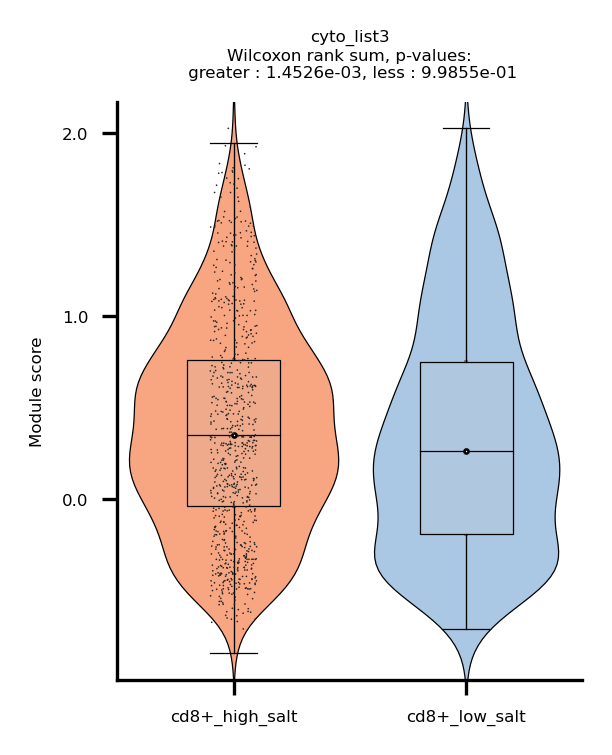

<Figure size 640x480 with 0 Axes>

In [33]:
for geneset_name, gene_set in pathways.items():
    df = module_score(adata_cd8, gene_set, geneset_name, 'sc_salt_group', ['cd8+_high_salt', 'cd8+_low_salt'], df)

In [34]:
df.to_csv('MAA_figures_info.csv', index=False)